In [61]:
!pip install emoji

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
data_dir = "/content/drive/MyDrive/train_twitter.csv"

In [64]:
#Import all necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import emoji
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
df = pd.read_csv(data_dir)

In [66]:
df.dropna(inplace=True)

In [67]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [68]:
print(df)

          id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]


In [69]:
label_counts = df['label'].value_counts()
label_counts

0    29720
1     2242
Name: label, dtype: int64

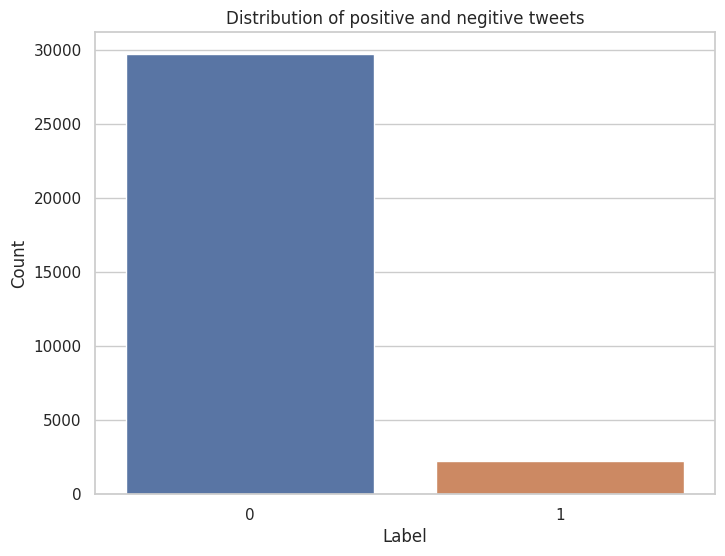

In [70]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of positive and negitive tweets')

plt.show()


In [71]:
positive = df[df['label']==0]
negative = df[df['label']==1]
df=pd.concat([df,positive,negative], axis=0)
df.shape

(63924, 3)

In [72]:
display(df['label'].value_counts().to_frame())

print("0s : 1s :: ",(df['label'].value_counts()[0]/df['label'].value_counts()[1]).round(2),": 1")

,label
0,59440
1,4484


0s : 1s ::  13.26 : 1


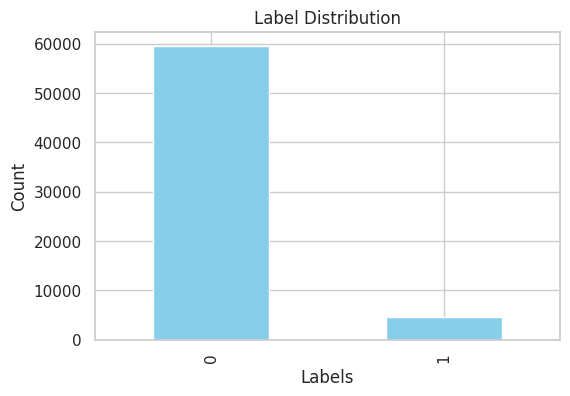

In [73]:

label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')


plt.show()


In [74]:
# Split into dependent (y) and independent (X) variables
y = df['label']
X = df['tweet']

In [75]:
# Remove emojis using a regular expression
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U0001F004-\U0001F0CF"
                               u"\U0001F170-\U0001F251"
                               "]+", flags=re.UNICODE)



In [76]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [77]:

def clean_text(text):
    text=remove_urls(text)
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub('[^A-Za-z\s]', '', text)
    text = emoji_pattern.sub('', text)
    text = text.lower()
    text = re.sub('\d+', '', text)
    text = text.strip()
    text = re.sub(" +", " ", text)

    return text


# Apply the clean_text function to the 'tweet' column in your dataset
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

df['cleaned_tweet'] = df['cleaned_tweet'].str.split()


# Remove stop words with NLTK
stop_words = set(stopwords.words('english'))
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Apply stemming to the cleaned text data
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])


# Create a list of cleaned texts
cleaned_tweet = [" ".join(tokens) for tokens in df['cleaned_tweet']]


In [78]:
max_length_cleaned = max(len(tweet) for tweet in df["tweet"])

print("Max length of a single tweet is now : ", max_length_cleaned)

Max length of a single tweet is now :  274


In [79]:
max_length_cleaned = max(len(tweet) for tweet in df["cleaned_tweet"])

print("Max length of a single tweet is now : ", max_length_cleaned)

Max length of a single tweet is now :  23


In [80]:

# Allocate dictionary size
vocab_size = 3000

# Create a tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

# Fit the tokenizer on the text
tokenizer.fit_on_texts(cleaned_tweet)

# Convert text to sequences of integers (one-hot encoding)
one_hot_encoded = tokenizer.texts_to_sequences(cleaned_tweet)

# Define the maximum sequence length
max_sequence_length =50

# Pad sequences to have the same length
padded_sequences = pad_sequences(one_hot_encoded, maxlen=max_sequence_length, padding='pre')

# 'padded_sequences' now contains your one-hot encoded and padded text data
padded_sequences

array([[   0,    0,    0, ..., 1796,  125,  188],
       [   0,    0,    0, ...,  421,   28,  859],
       [   0,    0,    0, ...,    0,   20, 2808],
       ...,
       [   0,    0,    0, ...,   66,  244, 1678],
       [   0,    0,    0, ...,  261,    5,  140],
       [   0,    0,    0, ..., 1417, 1116,  367]], dtype=int32)

In [81]:
#convert in numpy arrays.
x = np.array(padded_sequences)
y = np.array(y)

In [82]:
#Splitting the Dataset into Train and Test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [83]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
#create the model using LSTM
model = Sequential()
model.add(Embedding(vocab_size,64,input_length = len(padded_sequences[0])))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1,activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.summary()
history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, batch_size = 32)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 64)            192000    
                                                                 
 lstm_2 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 258,101
Trainable params: 258,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1599/1599 [==============================] - 147s 86ms/step - loss: 0.2174 - accuracy: 0.9497 - val_loss: 0.1639 - val_accuracy: 0.9587
Epoch 2/10
1599/1599 [===========

In [84]:
model.save('new_model')

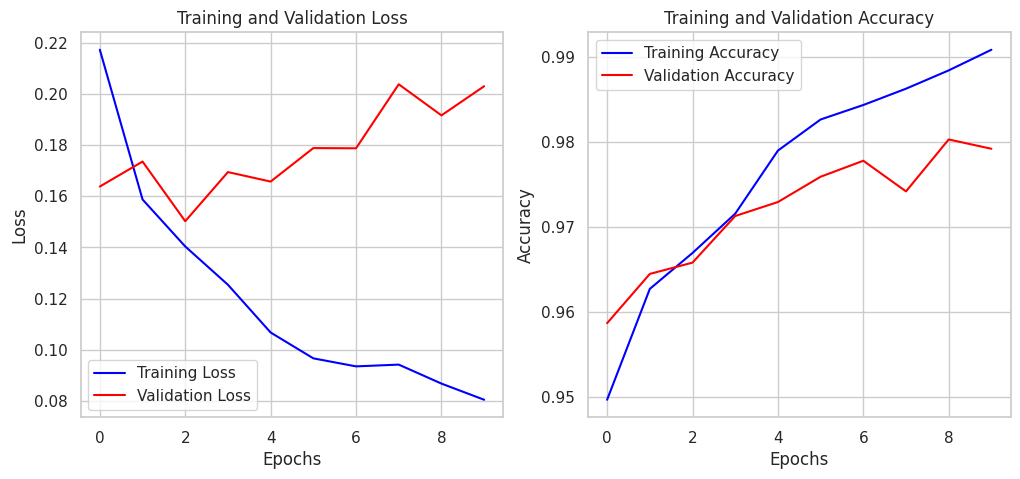

In [85]:

training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.plot(training_loss, label='Training Loss', color='blue')
ax1.plot(validation_loss, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(training_accuracy, label='Training Accuracy', color='blue')
ax2.plot(validation_accuracy, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()


plt.show()


In [86]:
# Import necessary libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test data
y_pred = model.predict(x_test)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


400/400 [==============================] - 9s 20ms/step
Accuracy: 0.9792
Precision: 0.8790
Recall: 0.8258
F1 Score: 0.8516
Confusion Matrix:
[[11756   105]
 [  161   763]]


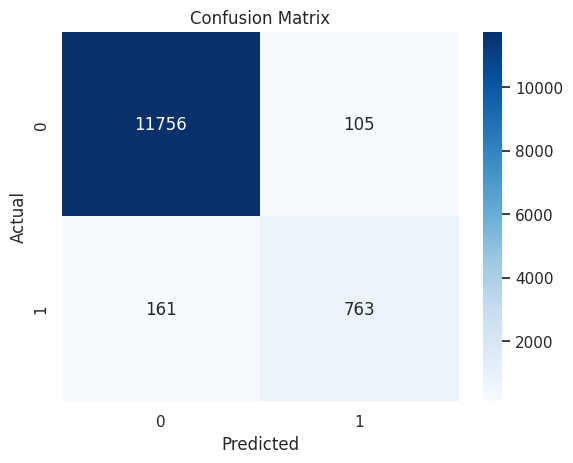

In [87]:

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [88]:
# Loading LSTM model
from tensorflow.keras.models import load_model

# Load your previously trained model
model = load_model('new_model')

import pandas as pd
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer


test_file = '/content/drive/MyDrive/test_twitter.csv'
stop_words = set(stopwords.words('english'))

# Load the test dataset
test_data = pd.read_csv(test_file)

# Clean and preprocess the test data
test_data['tweet'] = test_data['tweet'].apply(lambda x: re.sub('[^a-zA-Z\ ]', ' ', emoji.demojize(x)))
test_data['tweet'] = test_data['tweet'].apply(lambda x: remove_urls(x))
test_data['tweet'] = test_data['tweet'].apply(lambda x: x.lower())
test_data['tweet'] = test_data['tweet'].apply(lambda x: x.split())
test_data['tweet'] = test_data['tweet'].apply(lambda x: [word for word in x if word not in stop_words])
test_data['tweet'] = test_data['tweet'].apply(lambda x: [stemmer.stem(word) for word in x])
test_data['tweet'] = test_data['tweet'].apply(lambda x: ' '.join(x))

# Tokenize and pad the test data
max_words = 3000
maxlen = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test_data['tweet'])
test_sequences = tokenizer.texts_to_sequences(test_data['tweet'])
test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# Make predictions on the test data using the LSTM model
predictions = model.predict(test_sequences)




538/538 [==============================] - 10s 18ms/step


In [89]:
predictions

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [91]:
threshold = 1  # 1 vanda badi vayo vani racist/sexist

positive_count = 0
negative_count = 0

for prediction in predictions:
    if prediction < threshold:
        positive_count += 1
    else:
        negative_count += 1

print("Non racist/sexist:", positive_count)
print("Racist/sexist:", negative_count)

Non racist/sexist: 16824
Racist/sexist: 373
